In [0]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [0]:
# Create a SparkSession
spark = SparkSession.builder.appName("StockAnalysis").getOrCreate()

# Read the CSV file into a Spark DataFrame
stock_df = spark.read.csv("/FileStore/tables/META.csv", header=True, inferSchema=True)

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|
+----------+---------+---------+---------+---------+---------+---------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|
+----------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows



In [0]:
# Check for missing values in each column
stock_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in stock_df.columns]).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [0]:
# Calculate descriptive statistics to identify potential outliers
stock_df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|summary|              Open|              High|               Low|             Close|         Adj Close|              Volume|
+-------+------------------+------------------+------------------+------------------+------------------+--------------------+
|  count|              2906|              2906|              2906|              2906|              2906|                2906|
|   mean|156.55016523743973|158.58377143805927|154.57269793358543|156.61481418891952|156.61481418891952|3.0686863454920854E7|
| stddev| 90.03938994169701|   91.194870854983| 88.93687407308715|  90.0821560481394|  90.0821560481394|2.6423894750016544E7|
|    min|             18.08|             18.27|         17.549999|             17.73|             17.73|             5467500|
|    max|        381.679993|        384.329987|        378.809998|        382.179993|        382.179993|           573

Out[7]: array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Close'}>]], dtype=object)

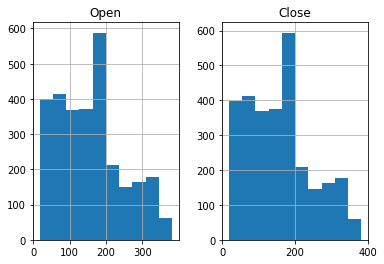

In [0]:
# Visualize distributions to examine outliers
stock_df.select("Open", "Close").toPandas().hist()

In [0]:
# Cap extreme values in "Close" at 3 standard deviations from the mean
max_close = stock_df.agg(F.mean("Close") + 3 * F.stddev("Close")).first()[0]
stock_df = stock_df.withColumn("Close", F.when(F.col("Close") > max_close, max_close).otherwise(F.col("Close")))

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|
+----------+---------+---------+---------+---------+---------+---------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|
+----------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows



In [0]:
selected_data = stock_df.select("Date", "Close", "Volume")
selected_data.show(5)

+----------+---------+---------+
|      Date|    Close|   Volume|
+----------+---------+---------+
|2012-05-18|    38.23|573576400|
|2012-05-21|34.029999|168192700|
|2012-05-22|     31.0|101786600|
|2012-05-23|     32.0| 73600000|
|2012-05-24|33.029999| 50237200|
+----------+---------+---------+
only showing top 5 rows



In [0]:
filtered_data = stock_df.filter(stock_df.High > 100)
filtered_data.show(5)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2015-10-23|101.910004|102.849998|100.160004|102.190002|102.190002|42809700|
|2015-10-26|102.199997|103.809998|101.550003|103.769997|103.769997|25961200|
|2015-10-27|102.940002|104.099998|102.400002|103.699997|103.699997|23795500|
|2015-10-28|103.900002|104.480003|102.919998|104.199997|104.199997|24081500|
|2015-10-29|103.959999|105.120003|103.519997|104.879997|104.879997|20316700|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows



In [0]:
ordered_data = stock_df.orderBy("Date", ascending=False)
ordered_data.show(5)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2023-12-05|318.980011|321.880005|315.390015|318.290009|318.290009|16926700|
|2023-12-04|317.290009|320.859985|313.660004|320.019989|320.019989|19037100|
|2023-12-01|325.480011|326.859985| 320.76001|324.820007|324.820007|15264700|
|2023-11-30|331.890015|     333.5|322.399994|327.149994|327.149994|23146400|
|2023-11-29|339.690002|339.899994|330.779999|332.200012|332.200012|16024500|
+----------+----------+----------+----------+----------+----------+--------+
only showing top 5 rows



In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import avg
windowSpec = Window.partitionBy().orderBy("Date")
rolling_avg_20 = avg(stock_df["Close"]).over(windowSpec.rowsBetween(-19, 0))
stock_df_with_avg = stock_df.withColumn("RollingAvg20", rolling_avg_20)
stock_df_with_avg.show(5)

+----------+---------+---------+---------+---------+---------+---------+-----------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|     RollingAvg20|
+----------+---------+---------+---------+---------+---------+---------+-----------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|            38.23|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|       36.1299995|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|34.41999966666666|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|      33.81499975|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|       33.6579996|
+----------+---------+---------+---------+---------+---------+---------+-----------------+
only showing top 5 rows



In [0]:
stock_df_with_returns = stock_df.withColumn("DailyReturn", (stock_df["Close"] - stock_df["Open"]) / stock_df["Open"])
stock_df_with_returns.show(5)

+----------+---------+---------+---------+---------+---------+---------+--------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|         DailyReturn|
+----------+---------+---------+---------+---------+---------+---------+--------------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|-0.09084421143505861|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|-0.06843690305055854|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|-0.04937138763043881|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000| 0.02008284921635806|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|0.002427860320853...|
+----------+---------+---------+---------+---------+---------+---------+--------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import stddev

windowSpec = Window.partitionBy().orderBy("Date")
volatility_20 = stddev(stock_df_with_returns["DailyReturn"]).over(windowSpec.rowsBetween(-19, 0))
stock_df_with_volatility = stock_df_with_returns.withColumn("Volatility20", volatility_20)
stock_df_with_volatility.show(5)

+----------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|         DailyReturn|        Volatility20|
+----------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|-0.09084421143505861|                null|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|-0.06843690305055854|0.015844359706818186|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|-0.04937138763043881|0.020758839328512364|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000| 0.02008284921635806| 0.04791487834668569|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|0.002427860320853...| 0.04704592521264648|
+----------+---------+---------+---------+---------+---------+---------+--------

In [0]:
from pyspark.sql.functions import dayofweek, month

stock_df_with_date_info = stock_df.withColumn("DayOfWeek", dayofweek("Date")).withColumn("Month", month("Date"))
stock_df_with_date_info.show(5)

+----------+---------+---------+---------+---------+---------+---------+---------+-----+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|DayOfWeek|Month|
+----------+---------+---------+---------+---------+---------+---------+---------+-----+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|        6|    5|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|        2|    5|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|        3|    5|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|        4|    5|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|        5|    5|
+----------+---------+---------+---------+---------+---------+---------+---------+-----+
only showing top 5 rows



In [0]:
monthly_averages = stock_df_with_date_info.groupBy("Month").agg(avg("Close"))
monthly_averages.show(5)

+-----+------------------+
|Month|        avg(Close)|
+-----+------------------+
|   12| 151.0721365085471|
|    1| 149.9202691883408|
|    6|156.35078439607838|
|    3| 148.3014936141078|
|    5|156.22979345454544|
+-----+------------------+
only showing top 5 rows



In [0]:
join_columns = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]

joined_data = stock_df_with_date_info.join(stock_df_with_returns, on=join_columns, how="inner")

joined_data.show(5)

+----------+---------+---------+---------+---------+---------+---------+---------+-----+--------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|DayOfWeek|Month|         DailyReturn|
+----------+---------+---------+---------+---------+---------+---------+---------+-----+--------------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|        6|    5|-0.09084421143505861|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|        2|    5|-0.06843690305055854|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|        3|    5|-0.04937138763043881|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|        4|    5| 0.02008284921635806|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|        5|    5|0.002427860320853...|
+----------+---------+---------+---------+---------+---------+---------+---------+-----+--------------------+
only showi

In [0]:
joined_data.createOrReplaceTempView("stock_view")
result = spark.sql("SELECT * FROM stock_view WHERE Close > 100")
result.show(5)

+----------+----------+----------+----------+----------+----------+--------+---------+-----+--------------------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|DayOfWeek|Month|         DailyReturn|
+----------+----------+----------+----------+----------+----------+--------+---------+-----+--------------------+
|2015-10-23|101.910004|102.849998|100.160004|102.190002|102.190002|42809700|        6|   10|0.002747502590619133|
|2015-10-26|102.199997|103.809998|101.550003|103.769997|103.769997|25961200|        2|   10|0.015362035675989379|
|2015-10-27|102.940002|104.099998|102.400002|103.699997|103.699997|23795500|        3|   10|0.007382892803907166|
|2015-10-28|103.900002|104.480003|102.919998|104.199997|104.199997|24081500|        4|   10|0.002887343544035693|
|2015-10-29|103.959999|105.120003|103.519997|104.879997|104.879997|20316700|        5|   10|0.008849538369079889|
+----------+----------+----------+----------+----------+----------+--------+---------+--

In [0]:
from pyspark.sql.window import Window
# Calculate a 20-day rolling average for closing price
windowSpec = Window.partitionBy("Date").orderBy("Date").rowsBetween(-19, 0)
stock_df = stock_df.withColumn("RollingAvg20", F.avg("Close").over(windowSpec))

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|RollingAvg20|
+----------+---------+---------+---------+---------+---------+---------+------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|       38.23|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|   34.029999|
|2012-05-22|32.610001|    33.59|30.940001|     31.0|     31.0|101786600|        31.0|
|2012-05-23|31.370001|     32.5|31.360001|     32.0|     32.0| 73600000|        32.0|
|2012-05-24|32.950001|33.209999|    31.77|33.029999|33.029999| 50237200|   33.029999|
+---

In [0]:
# Create a new column for lagged "Close" values
stock_df = stock_df.withColumn("CloseLag1", F.lag("Close", 1).over(Window.orderBy("Date")))

# Calculate daily return
stock_df = stock_df.withColumn("DailyReturn", (F.col("Close") - F.col("CloseLag1")) / F.col("CloseLag1"))

# Calculate 20-day standard deviation of daily returns
windowSpec = Window.orderBy("Date").rowsBetween(-19, 0)
stock_df = stock_df.withColumn("Volatility20", F.stddev("DailyReturn").over(windowSpec))

# Drop the intermediate column "CloseLag1" as we don't need it anymore
stock_df = stock_df.drop("CloseLag1")

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)
 |-- DailyReturn: double (nullable = true)
 |-- Volatility20: double (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|RollingAvg20|         DailyReturn|        Volatility20|
+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|       38.23|                null|                null|
|2012-05-21|36.529999|    36.66|     33.0|34.029999|34.029999|168192700|   34.029999|-0.10986

In [0]:
from pyspark.sql.functions import dayofweek, month
stock_df = stock_df.withColumn("DayOfWeek", dayofweek("Date"))
stock_df = stock_df.withColumn("Month", month("Date"))

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)
 |-- DailyReturn: double (nullable = true)
 |-- Volatility20: double (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+---------+-----+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|RollingAvg20|         DailyReturn|        Volatility20|DayOfWeek|Month|
+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+---------+-----+
|2012-05-18|42.049999|     45.0|     38.0|    38.23|    38.23|573576400|       38.23|        

In [0]:
# Calculate short-term EMA
short_window = 12
stock_df = stock_df.withColumn("ShortEMA", F.avg("Close").over(Window.orderBy("Date").rowsBetween(-short_window+1, 0)))

In [0]:
# Calculate long-term EMA
long_window = 26
stock_df = stock_df.withColumn("LongEMA", F.avg("Close").over(Window.orderBy("Date").rowsBetween(-long_window+1, 0)))

In [0]:
# Calculate MACD
stock_df = stock_df.withColumn("MACD", F.col("ShortEMA") - F.col("LongEMA"))

In [0]:
# Calculate Signal Line (9-day EMA of MACD)
signal_window = 9
stock_df = stock_df.withColumn("SignalLine", F.avg("MACD").over(Window.orderBy("Date").rowsBetween(-signal_window+1, 0)))

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)
 |-- DailyReturn: double (nullable = true)
 |-- Volatility20: double (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- ShortEMA: double (nullable = true)
 |-- LongEMA: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- SignalLine: double (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+---------+-----+-----------------+-----------------+----+----------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|RollingAvg20|         DailyReturn|        Volatility20|DayOfWeek|Month|         ShortEMA|          L

In [0]:
# Create lagged columns in the original DataFrame
lag_window = Window.orderBy("Date")
stock_df = stock_df.withColumn("LaggedClose", F.lag("Close", 5).over(lag_window).alias("LaggedClose"))
stock_df = stock_df.withColumn("LaggedVolume", F.lag("Volume", 5).over(lag_window).alias("LaggedVolume"))

In [0]:
# Create a feature indicating strong uptrend days
stock_df = stock_df.withColumn("StrongUptrend", (F.col("Close") > F.lag("Close", 5).over(lag_window) * 1.05) & (F.col("Volume") > F.lag("Volume", 5).over(lag_window) * 1.2))

In [0]:
# Drop the columns used for lagging, if needed
stock_df = stock_df.drop("LaggedClose", "LaggedVolume")

In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)
 |-- DailyReturn: double (nullable = true)
 |-- Volatility20: double (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- ShortEMA: double (nullable = true)
 |-- LongEMA: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- SignalLine: double (nullable = true)
 |-- StrongUptrend: boolean (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+---------+-----+-----------------+-----------------+----+----------+-------------+
|      Date|     Open|     High|      Low|    Close|Adj Close|   Volume|RollingAvg20|         DailyReturn|      

In [0]:
stock_df = stock_df.withColumn("Date", F.to_date("Date"))

In [0]:
# 1. Rolling Average Calculation
rolling_window = Window.orderBy("Date").rowsBetween(-19, 0)
stock_df = stock_df.withColumn("RollingAvgClose", F.avg("Close").over(rolling_window))

In [0]:
# 2. Daily Returns Calculation
stock_df = stock_df.withColumn("DailyReturn", (F.col("Close") - F.lag("Close").over(Window.orderBy("Date"))) / F.lag("Close").over(Window.orderBy("Date")))

In [0]:
# 3. Autocorrelation Calculation
autocorrelation_window = Window.orderBy("Date")
stock_df = stock_df.withColumn("LaggedClose", F.lag("Close").over(autocorrelation_window))
autocorrelation = stock_df.select("Close", "LaggedClose").na.drop()

In [0]:
# Calculate Autocorrelation
autocorrelation = autocorrelation.groupBy().agg(F.corr("Close", "LaggedClose").alias("Autocorrelation"))


In [0]:
# Display the DataFrame's schema and some sample rows
stock_df.printSchema()
stock_df.show(5)

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- RollingAvg20: double (nullable = true)
 |-- DailyReturn: double (nullable = true)
 |-- Volatility20: double (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- ShortEMA: double (nullable = true)
 |-- LongEMA: double (nullable = true)
 |-- MACD: double (nullable = true)
 |-- SignalLine: double (nullable = true)
 |-- StrongUptrend: boolean (nullable = true)
 |-- RollingAvgClose: double (nullable = true)
 |-- LaggedClose: double (nullable = true)

+----------+---------+---------+---------+---------+---------+---------+------------+--------------------+--------------------+---------+-----+-----------------+-----------------+----+----------+-------------+-----------------+-----

In [0]:
# Display the autocorrelation results
autocorrelation.show()

+------------------+
|   Autocorrelation|
+------------------+
|0.9988618955549502|
+------------------+



In [0]:
# Visualize Trends and Autocorrelation
stock_df_pd = stock_df.toPandas()
autocorrelation_pd = autocorrelation.toPandas()

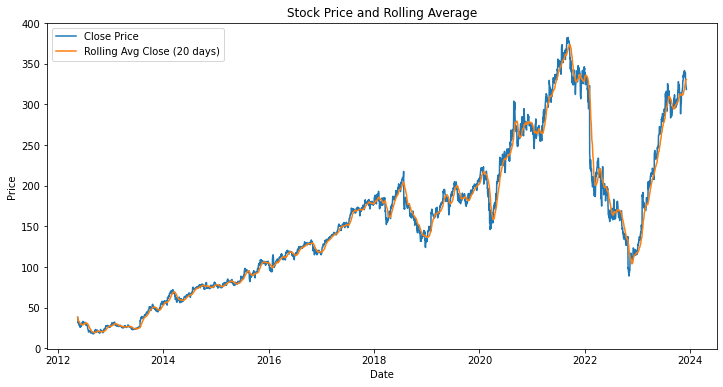

In [0]:
import matplotlib.pyplot as plt
# Plotting Trends
plt.figure(figsize=(12, 6))
plt.plot(stock_df_pd["Date"], stock_df_pd["Close"], label="Close Price")
plt.plot(stock_df_pd["Date"], stock_df_pd["RollingAvgClose"], label="Rolling Avg Close (20 days)")
plt.title("Stock Price and Rolling Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

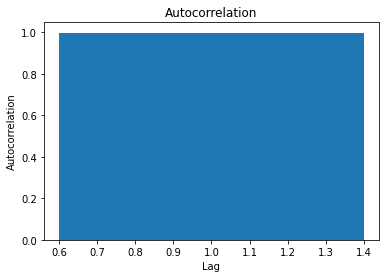

In [0]:
# Plotting Autocorrelation
plt.bar(range(1, len(autocorrelation_pd) + 1), autocorrelation_pd["Autocorrelation"])
plt.title("Autocorrelation")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [0]:
stock_df = stock_df.dropna()

In [0]:
from pyspark.sql.functions import when, col
stock_df = stock_df.withColumn("label", when(col("StrongUptrend"), 1).otherwise(0))

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier


In [0]:
label_col = 'label'

# Extracting numeric feature columns
numeric_feature_cols = [col for col in stock_df.columns if col != label_col and 'date' not in col.lower()]

In [0]:
# Assemble features into a vector
vector_assembler = VectorAssembler(inputCols=numeric_feature_cols, outputCol="features")
assembled_df = vector_assembler.transform(stock_df)

In [0]:
# ChiSqSelector for feature selection
selector = ChiSqSelector(numTopFeatures=5, featuresCol="features", outputCol="selectedFeatures", labelCol=label_col)
result = selector.fit(assembled_df).transform(assembled_df)

In [0]:
# Train a RandomForestClassifier to get feature importances
rf = RandomForestClassifier(labelCol=label_col, featuresCol="features")
pipeline = Pipeline(stages=[selector, rf])
model = pipeline.fit(assembled_df)

In [0]:
# Get feature importances
feature_importances = model.stages[1].featureImportances

# Display feature importances
print("\nFeature Importances:")
for i in range(len(numeric_feature_cols)):
    print(f"{numeric_feature_cols[i]}: {feature_importances[i]}")


Feature Importances:
Open: 0.002837852102987648
High: 0.0021418985717758772
Low: 0.0017697942960527208
Close: 0.00670684199206147
Adj Close: 0.0005555423459730302
Volume: 0.04449370196066066
RollingAvg20: 0.0006597889088805301
DailyReturn: 0.05514239299498781
Volatility20: 0.003983320134250715
DayOfWeek: 0.0017729013700184734
Month: 0.0034642215662306227
ShortEMA: 0.004657435174557296
LongEMA: 0.006600159643424618
MACD: 0.006913256415128181
SignalLine: 0.00922883624990764
StrongUptrend: 0.8340834191795317
RollingAvgClose: 0.010805571067547197
LaggedClose: 0.004183066026023602


In [0]:
import matplotlib.pyplot as plt
import numpy as np


In [0]:
# Feature_importances is a SparseVector
feature_names = numeric_feature_cols

In [0]:
# Convert SparseVector to dense array
dense_importances = np.array(feature_importances.toArray())

In [0]:
# Rank features based on importances
sorted_indices = dense_importances.argsort()[::-1]
sorted_features = [numeric_feature_cols[i] for i in sorted_indices]
sorted_importances = dense_importances[sorted_indices]

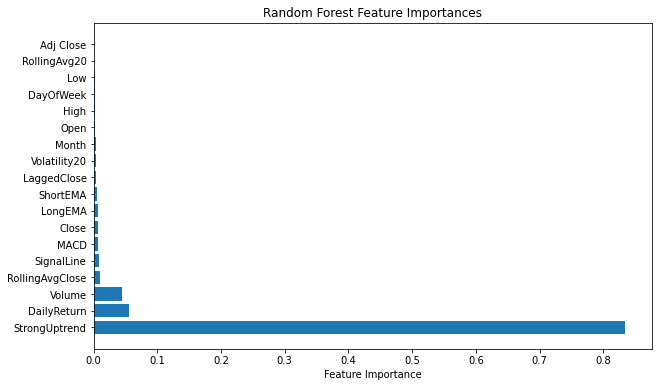

In [0]:
# Bar chart to visualize feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importances, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()